#--------------------------------------------------------------
## Mohamed Chouki Benkadja
## Projet Big Data 
#--------------------------------------------------------------

In [305]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer 
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel 
from pyspark.ml import Pipeline, PipelineModel 
from pyspark.mllib.evaluation import MulticlassMetrics 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

spark = (SparkSession.builder
         .master('local')
         .appName('Demo full pipeline')
         .getOrCreate())


## Chargement du dataset


In [306]:

rawdata = spark.read.options(header='True', inferSchema='True').format("csv").load("Loan.csv")

## printSchema
rawdata.printSchema()


root
 |-- ID: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- loan_limit: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- approv_in_adv: string (nullable = true)
 |-- loan_type: string (nullable = true)
 |-- loan_purpose: string (nullable = true)
 |-- Credit_Worthiness: string (nullable = true)
 |-- open_credit: string (nullable = true)
 |-- business_or_commercial: string (nullable = true)
 |-- loan_amount: integer (nullable = true)
 |-- rate_of_interest: double (nullable = true)
 |-- Interest_rate_spread: double (nullable = true)
 |-- Upfront_charges: double (nullable = true)
 |-- term: double (nullable = true)
 |-- Neg_ammortization: string (nullable = true)
 |-- interest_only: string (nullable = true)
 |-- lump_sum_payment: string (nullable = true)
 |-- property_value: double (nullable = true)
 |-- construction_type: string (nullable = true)
 |-- occupancy_type: string (nullable = true)
 |-- Secured_by: string (nullable = true)
 |-- total_unit

## Exploration/visualisation/nettoyage

# Pandas 

In [43]:
df0 = rawdata.toPandas()
df0

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,173555,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,...,CIB,659,EXP,55-64,to_inst,71.792763,south,direct,0,48.0
148666,173556,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,CIB,569,CIB,25-34,not_inst,74.428934,south,direct,0,15.0
148667,173557,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,CIB,702,EXP,45-54,not_inst,61.332418,North,direct,0,49.0
148668,173558,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,EXP,737,EXP,55-64,to_inst,70.683453,North,direct,0,29.0


In [37]:
df0.columns

Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status', 'dtir1'],
      dtype='object')

In [241]:
df0['age']

0         25-34
1         55-64
2         35-44
3         45-54
4         25-34
          ...  
148665    55-64
148666    25-34
148667    45-54
148668    55-64
148669    45-54
Name: age, Length: 148670, dtype: object

On remarque que l'age est classé par tranche d'age 

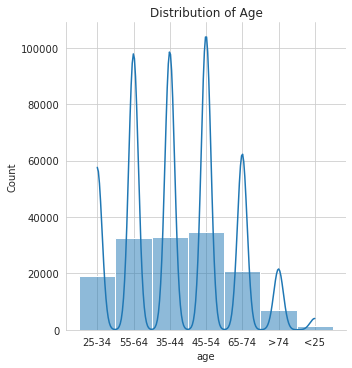

In [76]:
## Distribution de 'age'
sns.displot(x='age',data=df,kde=True)
plt.title('Distribution of Age')
plt.show()


In [38]:
df0.dtypes

ID                             int32
year                           int32
loan_limit                    object
Gender                        object
approv_in_adv                 object
loan_type                     object
loan_purpose                  object
Credit_Worthiness             object
open_credit                   object
business_or_commercial        object
loan_amount                    int32
rate_of_interest             float64
Interest_rate_spread         float64
Upfront_charges              float64
term                         float64
Neg_ammortization             object
interest_only                 object
lump_sum_payment              object
property_value               float64
construction_type             object
occupancy_type                object
Secured_by                    object
total_units                   object
income                       float64
credit_type                   object
Credit_Score                   int32
co-applicant_credit_type      object
a

## Nettoyage des données 

#### On remarque que nous avons des valeurs manquantes 

#### La fonction isnull() cherche les valeurs null dans le tableau et sum() pour la somme 

In [244]:
df0.isnull().sum().sort_values(ascending=False)

Upfront_charges              39642
Interest_rate_spread         36639
rate_of_interest             36439
dtir1                        24121
LTV                          15098
property_value               15098
income                        9150
loan_limit                    3344
approv_in_adv                  908
age                            200
loan_purpose                   134
Neg_ammortization              121
term                            41
Region                           0
submission_of_application        0
total_units                      0
Security_Type                    0
Status                           0
co-applicant_credit_type         0
Credit_Score                     0
credit_type                      0
ID                               0
Secured_by                       0
occupancy_type                   0
construction_type                0
year                             0
interest_only                    0
loan_amount                      0
business_or_commerci

### on voit que les colonnes :

* Upfront_charges              39642

* Interest_rate_spread         36639

* rate_of_interest             36439

### ont plus de 20% de valeurs manquantes 

In [242]:
df0.corr()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
ID,1.000000,NaN,-0.000566,0.000442,0.002338,-0.005507,-0.004056,0.000990,0.002535,-0.001036,-0.005853,0.001703,-0.008132
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amount,-0.000566,NaN,1.000000,-0.150844,-0.377272,0.065556,0.174474,0.734249,0.456065,0.004438,0.038869,-0.036825,0.015029
rate_of_interest,0.000442,NaN,-0.150844,1.000000,0.614908,-0.076473,0.209330,-0.122613,-0.041809,-0.001331,-0.000220,0.022957,0.055124
Interest_rate_spread,0.002338,NaN,-0.377272,0.614908,1.000000,0.033037,-0.157139,-0.334571,-0.151333,-0.001738,0.040257,NaN,0.078178
Upfront_charges,-0.005507,NaN,0.065556,-0.076473,0.033037,1.000000,-0.054960,0.053043,0.016580,-0.001484,-0.031347,-0.019138,0.000115
term,-0.004056,NaN,0.174474,0.209330,-0.157139,-0.054960,1.000000,0.045117,-0.053785,-0.003149,0.106834,-0.000240,0.110572
property_value,0.000990,NaN,0.734249,-0.122613,-0.334571,0.053043,0.045117,1.000000,0.414883,0.002430,-0.215102,-0.048864,-0.056288
income,0.002535,NaN,0.456065,-0.041809,-0.151333,0.016580,-0.053785,0.414883,1.000000,0.000802,-0.066203,-0.065119,-0.267807
Credit_Score,-0.001036,NaN,0.004438,-0.001331,-0.001738,-0.001484,-0.003149,0.002430,0.000802,1.000000,-0.005533,0.004004,-0.000313


In [307]:
df = df0.drop(['ID', 'year'], axis = 1)


### j'ai supprimé la colonne ID et année 

In [48]:
df.describe()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [46]:
df.shape

(148670, 32)

In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 145326 non-null  object 
 1   Gender                     148670 non-null  object 
 2   approv_in_adv              147762 non-null  object 
 3   loan_type                  148670 non-null  object 
 4   loan_purpose               148536 non-null  object 
 5   Credit_Worthiness          148670 non-null  object 
 6   open_credit                148670 non-null  object 
 7   business_or_commercial     148670 non-null  object 
 8   loan_amount                148670 non-null  int32  
 9   rate_of_interest           112231 non-null  float64
 10  Interest_rate_spread       112031 non-null  float64
 11  Upfront_charges            109028 non-null  float64
 12  term                       148629 non-null  float64
 13  Neg_ammortization          14

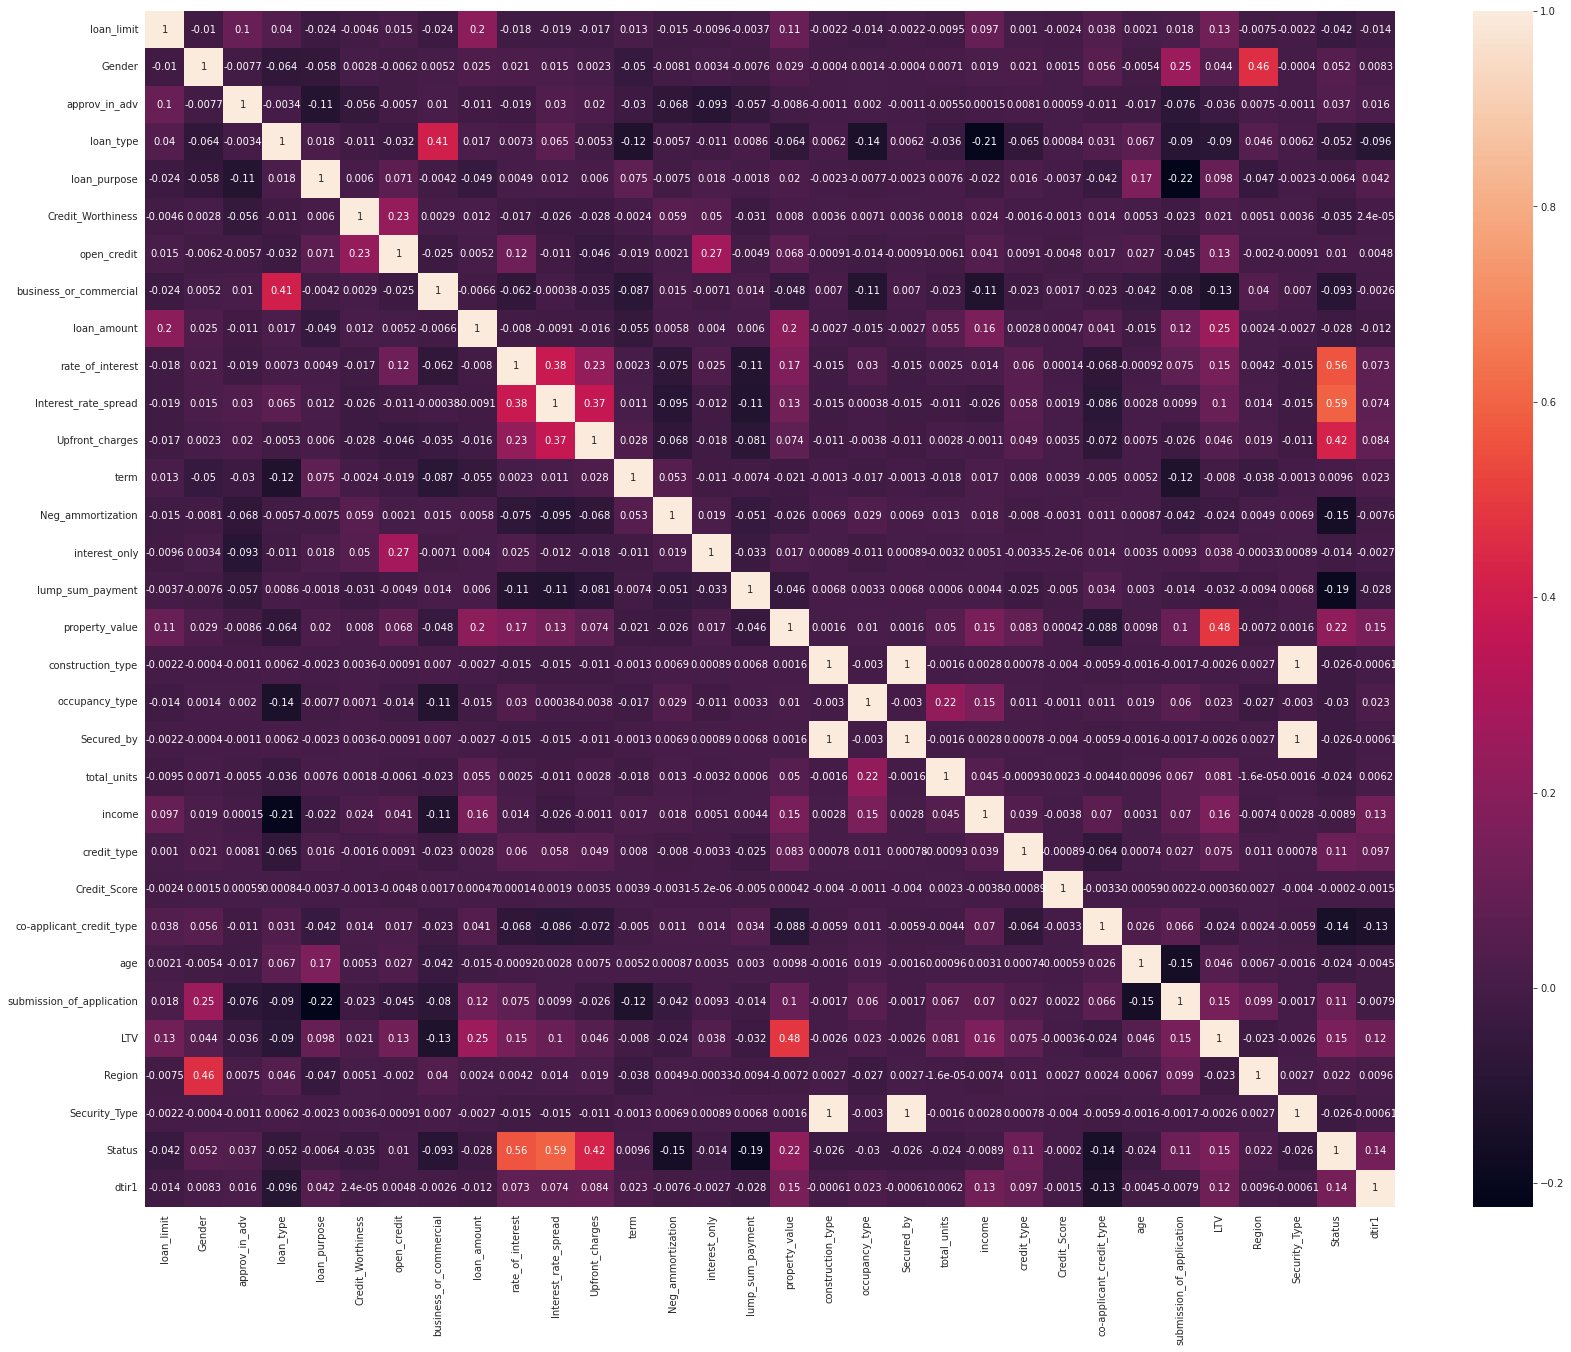

In [311]:
## Corrélation: avec les valeurs non numériques
corrDF = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
corrDF
plt.figure(figsize=(28,22))
sns.heatmap(corrDF, annot=True)
plt.show()

#### On remarque que les variables Security_type, construction_type et Secured_by ont une corrélation égale à 1. cela signifie que garder ces trois variables nous ne donnent pas plus informations nous gardons qu'une seule variable de ces trois

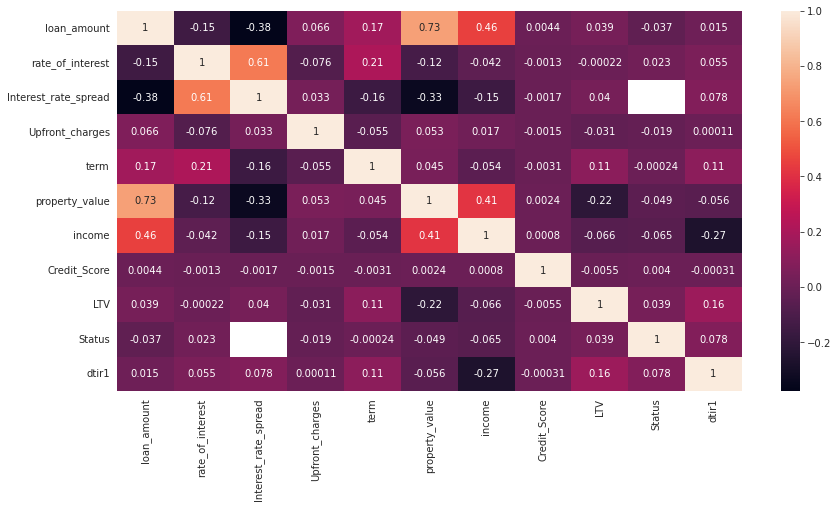

In [312]:
## Corrélation: heat map (valeurs numériques uniquement)
plt.figure(figsize=(14,7))
cor = df.corr()
sns.heatmap(cor, annot=True)
plt.show()

#### On remarque que la variable Interest_rate_spread à une corrélation égale à 1 avec Status 

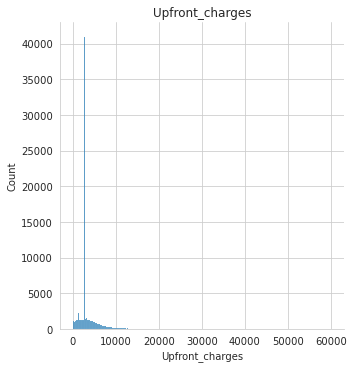

In [301]:
## Distribution de 'Upfront_charges'
sns.displot(x='Upfront_charges',data= df,kde=False)
plt.title('Upfront_charges')
plt.show()

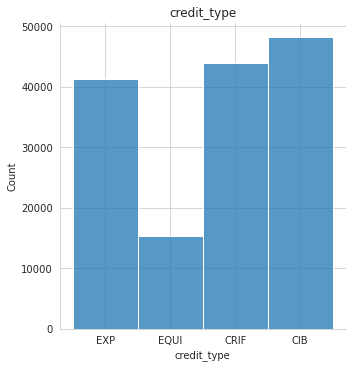

In [114]:
## Distribution de 'credit_type'
sns.displot(x='credit_type',data= df,kde=False)
plt.title('credit_type')
plt.show()


<AxesSubplot:xlabel='age', ylabel='count'>

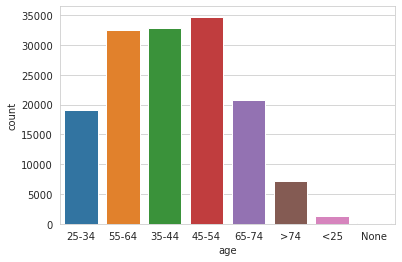

In [115]:
## Age
sns.set_style('whitegrid')
sns.countplot(x='age',data=df)

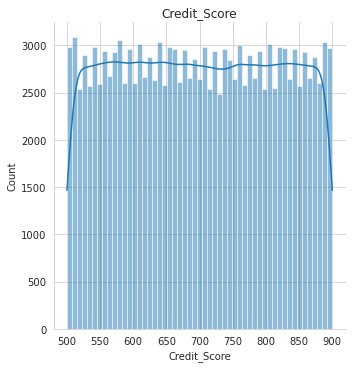

In [96]:
## Distribution de 'Credit_Score'
sns.displot(x='Credit_Score',data=df,kde=True)
plt.title('Credit_Score')
plt.show()

<AxesSubplot:xlabel='Region', ylabel='count'>

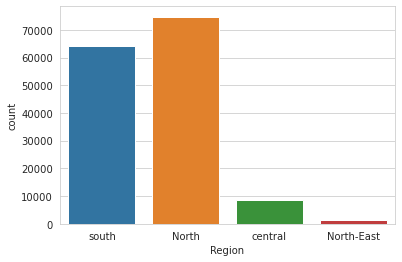

In [94]:
## region 
sns.set_style('whitegrid')
sns.countplot(x='Region',data=df)

<AxesSubplot:xlabel='Status', ylabel='count'>

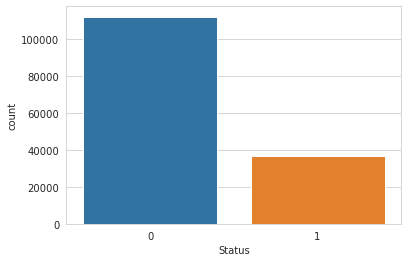

In [98]:
## Status 
sns.set_style('whitegrid')
sns.countplot(x='Status',data=df)

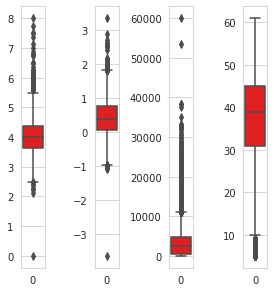

In [343]:
## outliers
numericDF = df[['rate_of_interest',
'Interest_rate_spread',
'Upfront_charges',
'dtir1']].copy()
l = numericDF.columns.values
number_of_columns= 7
number_of_rows = round(len(l)-1/number_of_columns)
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows+1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(data=numericDF[l[i]],color="red",orient="v")
    plt.tight_layout()
	

## Remplacement les valeurs manquantes :

#### On a cherché et séparé les valeurs numériques et catégoriques pour deux raisons

#### * Remplissage des valeurs manquantes

#### * Encoder les valeurs catégoriques

#### pour cela on a utilisé la fonction selecte_dtypes

In [118]:
num_features = df.select_dtypes(include=["int64", "float64"]).columns
num_features

Index(['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term',
       'property_value', 'income', 'LTV', 'dtir1'],
      dtype='object')

In [200]:
cat_features = df.select_dtypes(include="object").columns
cat_features

Index(['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'Credit_Worthiness', 'open_credit', 'business_or_commercial',
       'Neg_ammortization', 'interest_only', 'lump_sum_payment',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'credit_type', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'Region', 'Security_Type'],
      dtype='object')



### Par la suite on a remplacé les valeurs numériques manquantes par le median et les valeurs catégoriques par "None"

In [120]:
for i in num_features:
  print(i)
  df[i].fillna(df[i].median(), inplace =True)

rate_of_interest
Interest_rate_spread
Upfront_charges
term
property_value
income
LTV
dtir1


In [201]:
for i in cat_features:
  print(i)
  df[i].fillna('None', inplace= True)

loan_limit
Gender
approv_in_adv
loan_type
loan_purpose
Credit_Worthiness
open_credit
business_or_commercial
Neg_ammortization
interest_only
lump_sum_payment
construction_type
occupancy_type
Secured_by
total_units
credit_type
co-applicant_credit_type
age
submission_of_application
Region
Security_Type


#### On obtient un df sans les valeurs null 

In [202]:
df.isnull().sum().sort_values(ascending=False)

loan_limit                   0
Gender                       0
Status                       0
Security_Type                0
Region                       0
LTV                          0
submission_of_application    0
age                          0
co-applicant_credit_type     0
Credit_Score                 0
credit_type                  0
income                       0
total_units                  0
Secured_by                   0
occupancy_type               0
construction_type            0
property_value               0
lump_sum_payment             0
interest_only                0
Neg_ammortization            0
term                         0
Upfront_charges              0
Interest_rate_spread         0
rate_of_interest             0
loan_amount                  0
business_or_commercial       0
open_credit                  0
Credit_Worthiness            0
loan_purpose                 0
loan_type                    0
approv_in_adv                0
dtir1                        0
dtype: i

In [344]:
df.dtypes
df.shape

(148670, 32)

# Modèle 1

## Sélection des informations

####  df avec des lignes non Null et sans les colonnes suivantes :

##### "rate_of_interest", "Upfront_charges", "Interest_rate_spread" parceque les colonnes ont plus de 20% des valeurs manquantes 

##### et sans les colonnes 'Security_type', 'construction_type'

In [274]:
sdf = spark.createDataFrame(df)

In [275]:
Indexer = StringIndexer(inputCol='' , outputCol="_Num")
Encoder = OneHotEncoder(inputCols=["_Num"], outputCols=["_Vector"])

### Etape 1 du pipeline: indexing 

In [276]:

loan_limitIndexer = StringIndexer(inputCol='loan_limit' , outputCol="loan_limit_Num")

GenderIndexer = StringIndexer(inputCol= 'Gender' , outputCol="Gender_Num")

approv_in_advIndexer = StringIndexer(inputCol='approv_in_adv' , outputCol="approv_in_adv_Num")

loan_typeIndexer = StringIndexer(inputCol='loan_type' , outputCol="loan_type_Num")

loan_purposeIndexer = StringIndexer(inputCol='loan_purpose' , outputCol="loan_purpose_Num")

Credit_WorthinessIndexer = StringIndexer(inputCol='Credit_Worthiness' , outputCol="Credit_Worthiness_Num")

open_creditIndexer = StringIndexer(inputCol='open_credit' , outputCol="open_credit_Num")

business_or_commercialIndexer = StringIndexer(inputCol='business_or_commercial' , outputCol="business_or_commercial_Num")

Neg_ammortizationIndexer = StringIndexer(inputCol='Neg_ammortization' , outputCol="Neg_ammortization_Num")

interest_onlyIndexer = StringIndexer(inputCol='interest_only' , outputCol="interest_only_Num")

lump_sum_paymentIndexer = StringIndexer(inputCol='lump_sum_payment' , outputCol="lump_sum_payment_Num")

construction_typeIndexer = StringIndexer(inputCol='construction_type' , outputCol="construction_type_Num")

occupancy_typeIndexer = StringIndexer(inputCol='occupancy_type' , outputCol="occupancy_type_Num")

Secured_byIndexer = StringIndexer(inputCol='Secured_by' , outputCol="Secured_by_Num")

total_unitsIndexer = StringIndexer(inputCol='total_units' , outputCol="total_units_Num")

credit_typeIndexer = StringIndexer(inputCol='credit_type' , outputCol="credit_type_Num")

coapplicant_credit_typeIndexer = StringIndexer(inputCol='co-applicant_credit_type' , outputCol="co-applicant_credit_type_Num")



ageIndexer = StringIndexer(inputCol='age' , outputCol="age_Num")

submission_of_applicationIndexer = StringIndexer(inputCol='submission_of_application' , outputCol="submission_of_application_Num")

RegionIndexer = StringIndexer(inputCol='Region' , outputCol="Region_Num")

Security_TypeIndexer = StringIndexer(inputCol='Security_Type' , outputCol="Security_Type_Num")


### Etape 2 du pipeline: one hot encoder

In [277]:

loan_limitEncoder = OneHotEncoder(inputCols=["loan_limit_Num"], outputCols=["loan_limit_Vector"])

GenderEncoder = OneHotEncoder(inputCols=["Gender_Num"], outputCols=["Gender_Vector"])

approv_in_advEncoder = OneHotEncoder(inputCols=["approv_in_adv_Num"], outputCols=["approv_in_adv _Vector"])

loan_typeEncoder = OneHotEncoder(inputCols=["loan_type_Num"], outputCols=["loan_type_Vector"])

loan_purposeEncoder = OneHotEncoder(inputCols=["loan_purpose_Num"], outputCols=["loan_purpose_Vector"])

Credit_WorthinessEncoder = OneHotEncoder(inputCols=["Credit_Worthiness_Num"], outputCols=["Credit_Worthiness_Vector"])

open_creditEncoder = OneHotEncoder(inputCols=["open_credit_Num"], outputCols=["open_credit_Vector"])

business_or_commercialEncoder = OneHotEncoder(inputCols=["business_or_commercial_Num"], outputCols=["business_or_commercial_Vector"])

Neg_ammortizationEncoder = OneHotEncoder(inputCols=["Neg_ammortization_Num"], outputCols=["Neg_ammortization_Vector"])

interest_onlyEncoder = OneHotEncoder(inputCols=["interest_only_Num"], outputCols=["interest_only_Vector"])

lump_sum_paymentEncoder = OneHotEncoder(inputCols=["lump_sum_payment_Num"], outputCols=["lump_sum_payment_Vector"])

construction_typeEncoder = OneHotEncoder(inputCols=["construction_type_Num"], outputCols=["construction_type_Vector"])

occupancy_typeEncoder = OneHotEncoder(inputCols=["occupancy_type_Num"], outputCols=["occupancy_type_Vector"])

Secured_byEncoder = OneHotEncoder(inputCols=["Secured_by_Num"], outputCols=["Secured_by_Vector"])

total_unitsEncoder = OneHotEncoder(inputCols=["total_units_Num"], outputCols=["total_units_Vector"])

credit_typeEncoder = OneHotEncoder(inputCols=["credit_type_Num"], outputCols=["credit_type_Vector"])

coapplicant_credit_typeEncoder = OneHotEncoder(inputCols=["co-applicant_credit_type_Num"], outputCols=["co-applicant_credit_type_Vector"])

ageEncoder = OneHotEncoder(inputCols=["age_Num"], outputCols=["age_Vector"])

submission_of_applicationEncoder = OneHotEncoder(inputCols=["submission_of_application_Num"], outputCols=["submission_of_application_Vector"])

RegionEncoder = OneHotEncoder(inputCols=["Region_Num"], outputCols=["Region_Vector"])

Security_TypeEncoder = OneHotEncoder(inputCols=["Security_Type_Num"], outputCols=["Security_Type_Vector"])


### Etape 3 du pipeline: assembler 

In [332]:

dfAssembler = VectorAssembler(inputCols=
                              ["loan_limit_Vector","Gender_Vector","approv_in_adv _Vector",
                               "loan_type_Vector","loan_purpose_Vector",
                               "Credit_Worthiness_Vector","open_credit_Vector",
                               "business_or_commercial_Vector", "Neg_ammortization_Vector",
                               "interest_only_Vector","lump_sum_payment_Vector",
                               "occupancy_type_Vector",
                               "Secured_by_Vector", "total_units_Vector",
                               "credit_type_Vector",
                               "co-applicant_credit_type_Vector",
                               "age_Vector",
                               "submission_of_application_Vector","Region_Vector",
                               "loan_amount", "term",
                               "property_value", "income","Credit_Score",
                               "LTV", "dtir1"], outputCol="features")


### Etape 4 du pipeline: régression

In [333]:

logreg = LogisticRegression(labelCol="Status")


## Pipeline

In [335]:

pipeline = Pipeline(stages=
                    [loan_limitIndexer,loan_limitEncoder,
                     GenderIndexer,GenderEncoder,
                     approv_in_advIndexer,approv_in_advEncoder,
                     loan_typeIndexer,loan_typeEncoder,
                     loan_purposeIndexer,loan_purposeEncoder,
                     Credit_WorthinessIndexer, Credit_WorthinessEncoder,
                     open_creditIndexer, open_creditEncoder,
                     business_or_commercialIndexer,business_or_commercialEncoder,
                     Neg_ammortizationIndexer, Neg_ammortizationEncoder,
                     interest_onlyIndexer,interest_onlyEncoder,
                     lump_sum_paymentIndexer, lump_sum_paymentEncoder,
                     occupancy_typeIndexer, occupancy_typeEncoder,
                     Secured_byIndexer, Secured_byEncoder,
                     total_unitsIndexer, total_unitsEncoder,
                     credit_typeIndexer, credit_typeEncoder,
                     coapplicant_credit_typeIndexer,coapplicant_credit_typeEncoder,
                     ageIndexer,ageEncoder,
                     submission_of_applicationIndexer,submission_of_applicationEncoder,
                     RegionIndexer, RegionEncoder,
                     dfAssembler, logreg])

### Découpage du dataset 

In [336]:
trainDf, testDf = sdf.randomSplit([0.75, 0.25])

### Training results

In [337]:

model = pipeline.fit(trainDf)

## Première évaluation

In [338]:

trainingSummary = model.stages[-1].summary
roc = trainingSummary.roc.toPandas()

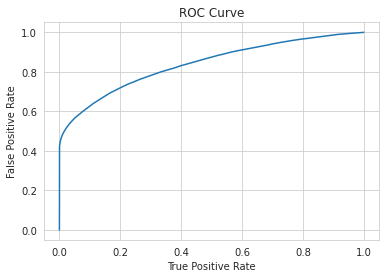

Training set areaUnderROC: 0.8386232060494675


In [339]:
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Résultats sur le test dataset

In [340]:
results = model.transform(testDf)

results.select("Status","prediction","rawPrediction","probability").show(40, truncate=False)

predictionAndLabels= results.rdd.map(lambda row: (float(row.Status), row.prediction))

+------+----------+----------------------------------------+------------------------------------------+
|Status|prediction|rawPrediction                           |probability                               |
+------+----------+----------------------------------------+------------------------------------------+
|0     |0.0       |[0.9281826503993038,-0.9281826503993038]|[0.716706439249406,0.283293560750594]     |
|1     |0.0       |[0.7925399257011172,-0.7925399257011172]|[0.6883764415299202,0.31162355847007983]  |
|0     |0.0       |[2.477062072878912,-2.477062072878912]  |[0.9225180597759214,0.07748194022407862]  |
|0     |0.0       |[1.5219464326410055,-1.5219464326410055]|[0.8208249238874401,0.1791750761125599]   |
|0     |0.0       |[2.249238533673523,-2.249238533673523]  |[0.9045848323391366,0.09541516766086344]  |
|0     |0.0       |[1.2859314505038633,-1.2859314505038633]|[0.783457748876458,0.21654225112354197]   |
|0     |0.0       |[1.596344244675695,-1.596344244675695]  |[0.8

### Instanciation métriques

In [341]:

metrics = MulticlassMetrics(predictionAndLabels)

# Matrice de confusion
print("Confusion matrix: %s" % metrics.confusionMatrix().toArray())
print("True negative: %s" % metrics.confusionMatrix().toArray()[0,0])
print("False positive: %s" % metrics.confusionMatrix().toArray()[0,1])
print("False negative: %s" % metrics.confusionMatrix().toArray()[1,0])
print("True positive: %s" % metrics.confusionMatrix().toArray()[1,1])
print("Accuracy = %s" % metrics.accuracy)

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion matrix: [[27815.  4696.]
 [  339.  4458.]]
True negative: 27815.0
False positive: 4696.0
False negative: 339.0
True positive: 4458.0
Accuracy = 0.8650423501661842


### notre matrice de confusion est précise à 86.50 % 

### BinaryClassificationEvaluator

In [317]:

evaluator = BinaryClassificationEvaluator(labelCol="Status",
                                          rawPredictionCol="rawPrediction", metricName="areaUnderPR")

In [286]:
print("Model accuracy : %s " % evaluator.evaluate(results))

# k-fold cross validator
cv = CrossValidator(estimator=pipeline, evaluator=evaluator, numFolds=5, collectSubModels=True)

Model accuracy : 0.7563821720143925 


In [287]:
params = ParamGridBuilder().addGrid(logreg.maxIter,[1000]).addGrid(logreg.regParam, [ 0.5, 0.05, 0.1,]).build()

In [288]:
cv.setEstimatorParamMaps(params)
cvmodel = cv.fit(trainDf)

bestModel = cvmodel.bestModel
print("Coefficients: \n %s" % bestModel.stages[43].coefficients)
print("Best regParam: %s" % bestModel.stages[43].getRegParam())


Coefficients: 
 [-0.1636461946668082,0.32232160825211814,0.1671647637910626,-0.40276457390214393,-0.032583206853894126,0.051290059298223084,-0.09216364028544112,-0.02137597059342548,0.19825749153811803,-0.03641980957859651,0.006203222507685589,0.0009071320324666266,0.30728788229489906,-0.24736887491067652,0.3852531876205122,-0.19825749153811797,-0.4390078142253237,0.43932308929202685,-0.17446688262193855,-1.8561233733846296,-1.3333075962416232,-0.18672003728183056,0.22233578818911412,-1.3333075962416232,-0.2424430891254074,0.23660971195557548,0.31559125868847965,-1.3174821849466267,-1.2898595760250215,-1.3098221632133866,-0.5182212900564843,0.002950368360353372,-0.08368966611388061,0.04608687245119238,0.03812747078497432,-0.08817566264669442,0.10802432014853583,0.07433121793908949,0.20453994281480328,-0.22980745916011514,-0.07674028156754276,0.0401049133385789,0.08805093506555073,-1.3333075962416232,3.6902079153137586e-07,7.308628620652273e-05,-2.534337794465408e-07,-1.7034034813295882

# Modèle 2

### df avec toutes les colonnes et toutes lignes non Null afin d'évaluer le modèle 1


In [318]:
# Pipeline
pipeline = Pipeline(stages=
                    [loan_limitIndexer,loan_limitEncoder,
                     GenderIndexer,GenderEncoder,
                     approv_in_advIndexer,approv_in_advEncoder,
                     loan_typeIndexer,loan_typeEncoder,
                     loan_purposeIndexer,loan_purposeEncoder,
                     Credit_WorthinessIndexer, Credit_WorthinessEncoder,
                     open_creditIndexer, open_creditEncoder,
                     business_or_commercialIndexer,business_or_commercialEncoder,
                     Neg_ammortizationIndexer, Neg_ammortizationEncoder,
                     interest_onlyIndexer,interest_onlyEncoder,
                     lump_sum_paymentIndexer, lump_sum_paymentEncoder,
                     construction_typeIndexer,construction_typeEncoder,
                     occupancy_typeIndexer, occupancy_typeEncoder,
                     Secured_byIndexer, Secured_byEncoder,
                     total_unitsIndexer, total_unitsEncoder,
                     credit_typeIndexer, credit_typeEncoder,
                     coapplicant_credit_typeIndexer,coapplicant_credit_typeEncoder,
                     ageIndexer,ageEncoder,
                     submission_of_applicationIndexer,submission_of_applicationEncoder,
                     RegionIndexer, RegionEncoder,
                     Security_TypeIndexer, Security_TypeEncoder,
                     dfAssemblerAll, logreg])

In [346]:
#--------------------------------------------------------------
# Etape du pipeline: assembler avec toutes les colones 
#--------------------------------------------------------------
dfAssemblerAll = VectorAssembler(inputCols=
                              ["loan_limit_Vector","Gender_Vector","approv_in_adv _Vector",
                               "loan_type_Vector","loan_purpose_Vector",
                               "Credit_Worthiness_Vector","open_credit_Vector",
                               "business_or_commercial_Vector", "Neg_ammortization_Vector",
                               "interest_only_Vector","lump_sum_payment_Vector",
                               "construction_type_Vector","occupancy_type_Vector",
                               "Secured_by_Vector", "total_units_Vector",
                               "credit_type_Vector",
                               "co-applicant_credit_type_Vector",
                               "age_Vector",
                               "submission_of_application_Vector",
                               "Region_Vector",
                               "Security_Type_Vector",
                               "rate_of_interest",
                               "Interest_rate_spread",
                               "Upfront_charges",
                               "loan_amount",
                               "term",
                               "property_value",
                               "income",
                               "Credit_Score",
                               "LTV",
                               "dtir1"], outputCol="features")


In [347]:
#--------------------------------------------------------------
# Découpage du dataset 
#--------------------------------------------------------------
trainDf, testDf = sdf.randomSplit([0.75, 0.25])

In [321]:
# Training results
model = pipeline.fit(trainDf)

In [322]:
# Première évaluation
trainingSummary = model.stages[-1].summary
roc = trainingSummary.roc.toPandas()

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


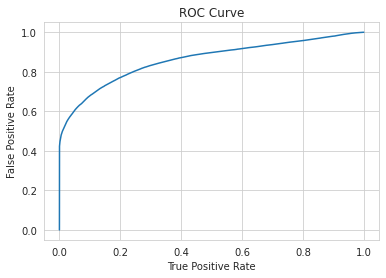

Training set areaUnderROC: 0.8606763044731923


In [323]:
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [324]:
#--------------------------------------------------------------
# Résultats sur le test dataset
#--------------------------------------------------------------
results = model.transform(testDf)

results.select("Status","prediction","rawPrediction","probability").show(40, truncate=False)

predictionAndLabels= results.rdd.map(lambda row: (float(row.Status), row.prediction))

+------+----------+------------------------------------------+------------------------------------------+
|Status|prediction|rawPrediction                             |probability                               |
+------+----------+------------------------------------------+------------------------------------------+
|0     |0.0       |[2.478994344028827,-2.478994344028827]    |[0.9226560628870076,0.07734393711299237]  |
|0     |0.0       |[3.2667460663358128,-3.2667460663358128]  |[0.9632702186475379,0.036729781352462076] |
|0     |0.0       |[2.5826696155445603,-2.5826696155445603]  |[0.9297378629245957,0.0702621370754043]   |
|0     |0.0       |[2.521160368769479,-2.521160368769479]    |[0.9256119908367361,0.07438800916326394]  |
|1     |0.0       |[1.6855301897379107,-1.6855301897379107]  |[0.8436354314984476,0.15636456850155245]  |
|0     |0.0       |[2.157972490122148,-2.157972490122148]    |[0.8964114293338468,0.10358857066615323]  |
|0     |0.0       |[3.6558068519393814,-3.6558

In [325]:
# Instanciation métriques
metrics = MulticlassMetrics(predictionAndLabels)

# Matrice de confusion
print("Confusion matrix: %s" % metrics.confusionMatrix().toArray())
print("True negative: %s" % metrics.confusionMatrix().toArray()[0,0])
print("False positive: %s" % metrics.confusionMatrix().toArray()[0,1])
print("False negative: %s" % metrics.confusionMatrix().toArray()[1,0])
print("True positive: %s" % metrics.confusionMatrix().toArray()[1,1])
print("Accuracy = %s" % metrics.accuracy)

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion matrix: [[27769.  4422.]
 [  366.  4714.]]
True negative: 27769.0
False positive: 4422.0
False negative: 366.0
True positive: 4714.0
Accuracy = 0.8715355101821792


##### Notre matrice de confusion est précise à 87.15 % avec toutes les colonnes on a un peu plus de précision par rapport à notre premier modèle donc les colonnes les colonnes "rate_of_interest", "Upfront_charges", "Interest_rate_spread", 'Security_type', 'construction_type' n'influence pas beaucoup

In [326]:
#--------------------------------------------------------------
# BinaryClassificationEvaluator
#--------------------------------------------------------------
evaluator = BinaryClassificationEvaluator(labelCol="Status",
                                          rawPredictionCol="rawPrediction", metricName="areaUnderPR")

In [327]:
print("Model accuracy : %s " % evaluator.evaluate(results))

# k-fold cross validator
cv = CrossValidator(estimator=pipeline, evaluator=evaluator, numFolds=5, collectSubModels=True)

Model accuracy : 0.7976463348484826 


In [328]:
params = ParamGridBuilder().addGrid(logreg.maxIter,[1000]).addGrid(logreg.regParam, [ 0.5, 0.05, 0.1,]).build()

In [329]:
cv.setEstimatorParamMaps(params)
cvmodel = cv.fit(trainDf)

bestModel = cvmodel.bestModel
print("Coefficients: \n %s" % bestModel.stages[43].coefficients)
print("Best regParam: %s" % bestModel.stages[43].getRegParam())


Coefficients: 
 [-0.17602985960899406,0.3367365857740276,0.14350724864255432,-0.41269436678689375,-0.030749884345885513,0.0616987225040931,-0.09894968327363668,0.1551167098696902,0.28357752732548724,0.04286274991342396,-0.0820312021504269,0.009820617165820205,0.35382988654628417,-0.304798845273247,0.11282056536498672,-0.28357752732548736,-0.4301677662996564,0.4337895429610006,-0.17173359715957187,-1.828263887475437,-1.339773041787239,-0.23987052129899736,0.34602440089962394,-1.339773041787239,-0.3409799195843871,0.27509990959387387,0.522492102723866,-1.2805821702394444,-1.258949869765317,-1.3026974175077417,-0.5167007888816851,-0.0013927968867699602,-0.07129474099822591,0.04684231458711137,0.021696531039520822,-0.09308821643370502,0.11757976600383771,0.09542710509981815,0.302855811930925,-0.33002464933589587,-0.0733070771381566,0.024765392710657776,0.12091695859372918,-1.339773041787239,-0.24103721400938508,-0.4357610717147987,-8.967008647709385e-05,3.764427751616833e-07,0.000101068663